
----------
## Комментарий от ревьюера

Привет! Меня зовут Дарья, я буду твоим ревьюером по этому проекту. Работа получилась очень хорошая, но у меня есть несколько замечаний, которые необходимо исправить.  

Мои комментарии в файле будут оформлены как этот, ты сможешь найти их по заголовку «Комментарий от ревьюера». 

Комментарий к заданию, выполненному на отлично, будет __<font color='green'>зеленым</font>__. \
__<font color='blue'>Синим</font>__ цветом будут выделены комментарии к заданиям, в которых ты всё сделал правильно, но есть незначительные неточности или у меня есть предложения по улучшению. \
Если какое-то задание я пока не могу принять, комментарий будет помечен __<font color='red'>красным</font>__. 

---------


## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

In [1]:
pip install -U scikit-learn --user

     |████████████████████████████████| 7.3 MB 138 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# 1. Подготовка

In [18]:
                                 import pandas as pd
                                 import seaborn as sns
                                 import numpy as np            
                                 import matplotlib.pyplot as plt
                                 import matplotlib.dates as mdates
from datetime                    import datetime, timedelta
from sklearn.model_selection     import TimeSeriesSplit
from sklearn.model_selection     import train_test_split
from sklearn.model_selection     import RandomizedSearchCV

from statsmodels.tsa.holtwinters import ExponentialSmoothing , SimpleExpSmoothing , Holt
from statsmodels.tsa.seasonal    import seasonal_decompose

from sklearn.linear_model        import LinearRegression
from sklearn.tree                import DecisionTreeRegressor 
from sklearn.ensemble            import RandomForestRegressor
from sklearn.metrics             import *



# 2. Анализ

In [19]:
df_taxi = pd.read_csv('/datasets/taxi.csv' , index_col=[0], parse_dates=[0])

In [20]:
df_taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [21]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [22]:
# Ресемплирование значений
df_taxi_hour=df_taxi.resample('1H').sum()

df_taxi_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


----------
<font color='green'>

## Комментарий от ревьюера

Отлично, ресемплирование сделано правильно.
</font>

---------

In [23]:
df_taxi_hour.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


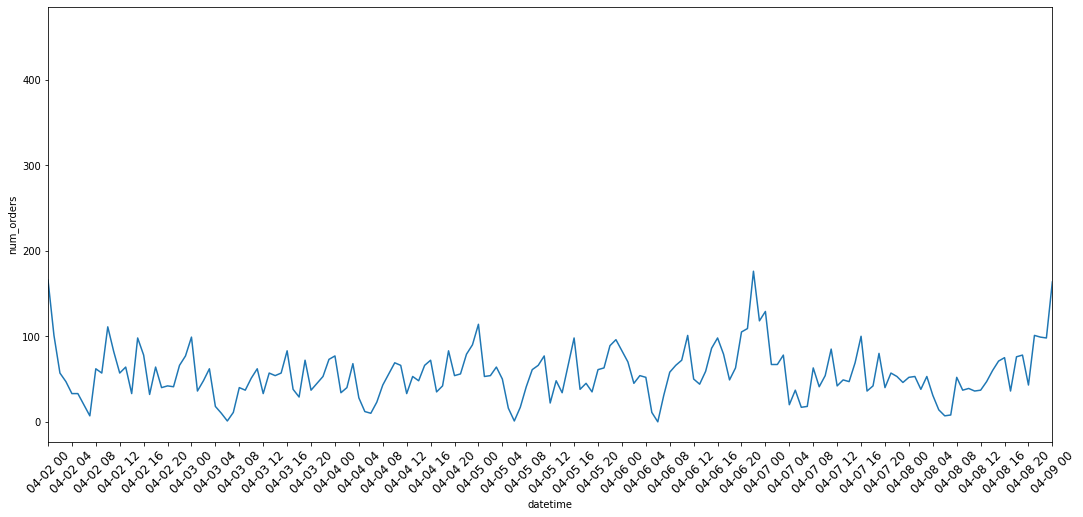

In [24]:
#График значений во времени
# Скользящее среднее
rolling_mean = df_taxi_hour['num_orders'].shift().rolling(24).mean()

# Задаем границы графика
start = '2018-04-02 00:00:00'
end = '2018-04-09 00:00:00'

# Строим график
plt.figure(figsize = (18,8))

ax = sns.lineplot(x = df_taxi_hour.index , y = df_taxi_hour['num_orders']  );
xplot = ax.get_xticklabels()
ax.set_xlim(start , end)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.xticks(rotation=45 , fontsize = 12)

plt.show()

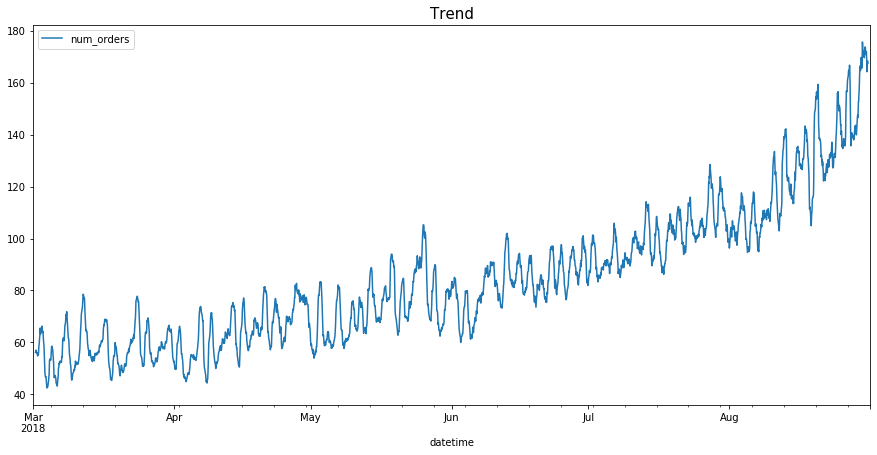

In [25]:
# Декомпозиция данных на составляющие
decomposed  = seasonal_decompose(df_taxi_hour)

# График тренда
plt.figure(figsize = (15,7) )
decomposed.trend.plot(ax=plt.gca() )
plt.title('Trend' , fontsize = 15)
plt.show()


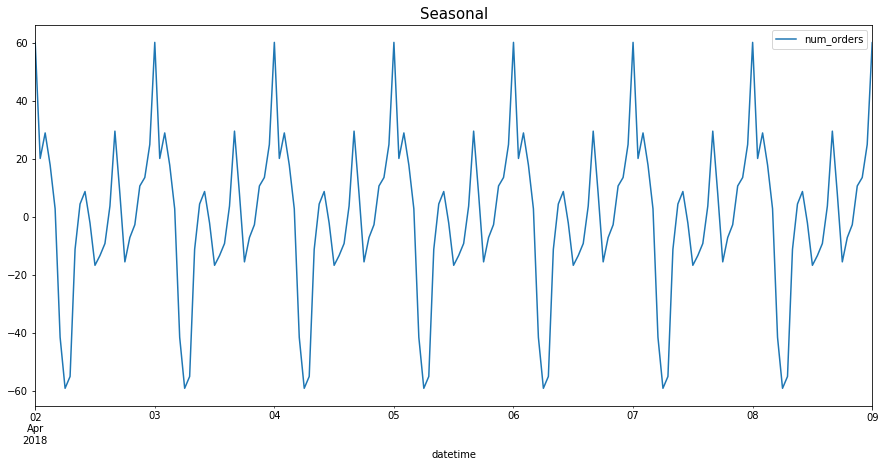

In [26]:
# График сезона
plt.figure(figsize = (15,7) )
decomposed.seasonal.plot(ax=plt.gca() )
plt.xlim(start , end)
plt.title('Seasonal' , fontsize = 15)
plt.show();

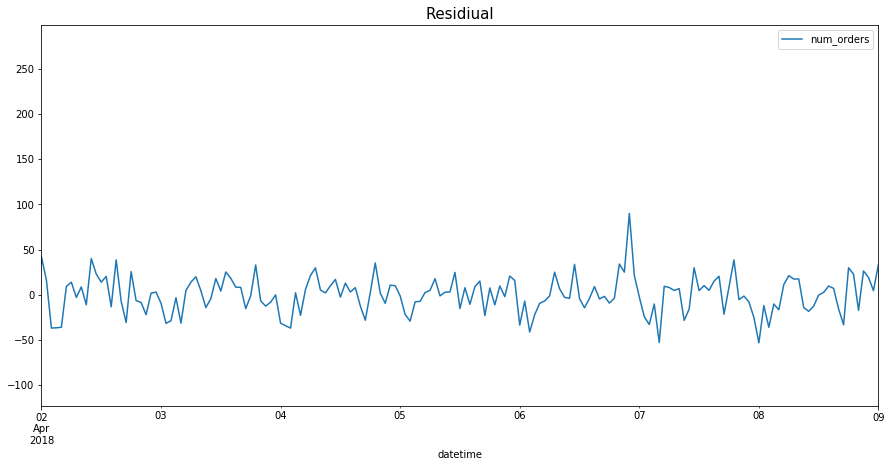

In [27]:
# График остатков
plt.figure(figsize = (15,7) )
decomposed.resid.plot(ax=plt.gca() )
plt.xlim(start , end)
plt.title('Residiual' , fontsize = 15)
plt.show();

In [35]:
# Создаем новые признаки
def new_features(data , lag , rolling_size):
    decomposed  = seasonal_decompose(data['num_orders'])
    data['trend'] = decomposed.trend
    data['seasonal'] = decomposed.seasonal
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1,lag+1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()
    
    data['is_weekend'] = data.index.dayofweek.isin([5,6])*1

    
    return data.dropna()

In [36]:
df_taxi_final = new_features(df_taxi_hour,24,3)
print('Размерность итоговой таблицы:' , df_taxi_final.shape)
df_taxi_final.head()

Размерность итоговой таблицы: (4380, 33)


,num_orders,trend,seasonal,month,day,dayofweek,hour,lag_1,lag_2,lag_3,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,54.833333,60.248112,3,2,4,0,58.0,113.0,66.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,79.000000,0
2018-03-02 01:00:00,120,55.229167,20.177074,3,2,4,1,90.0,58.0,113.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,87.000000,0
2018-03-02 02:00:00,75,55.416667,28.982743,3,2,4,2,120.0,90.0,58.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.333333,0
2018-03-02 03:00:00,64,55.187500,17.885407,3,2,4,3,75.0,120.0,90.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,95.000000,0
2018-03-02 04:00:00,20,55.854167,2.791145,3,2,4,4,64.0,75.0,120.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.333333,0


----------
<font color='green'>

## Комментарий от ревьюера

Отличная идея добавить признак "выходной день", может оказаться полезным :) 
    
Стоило попробовать несколько значений для lag, чтобы выбрать оптимальное отставание. Кстати, если есть периодичность, можно также добавлять признаки с отставанием в период: день/неделю/месяц назад.    
    
</font>


Ответ ученика: попробовал сделать признак с неделей и месяцем, но при этом удаляется большое количество данных, поэтому от этой идеи отказался
---------

### Вывод:
- данные ресмеплированы с шагом один час.
- построен часовой график количества вызовов с в предалах одной недели.
- методом seasonal_decompose() выполнена декомпозиция ряда на тренд и сезонность. Отчетливо видно снижение количества заказов в после 0 до 2 часов ночи, и повышение с 3 до 9 часов утра. Также хорошо заметен пик значений в пятницу вечером. Тренд и сезонность добавлены в датасет в качестве фичей.
- в датасет добавлены новые фичи: полученные из даты день недели, месяц и т.д. , значения целевой переменной с задержкой от 1 до 24 часов, и значения скользящей средней.




----------
<font color='red'>

## Комментарий от ревьюера

Анализ данных и выводы получились хорошие, но неполные: не хватает разложения временного ряда на компоненты. Сейчас ты определяешь сезонность по графику, который не очень для этого подходит. Стоит выделить сезонность с помощью декомпозиции и рассмотреть её период и закономерности отдельно. Также с помощью разложения мы можем узнать, какой у нашего ряда тренд :)
    
</font>

Ответ ученика: сезонность и тренд рассмотрены и добавлены в датасет.
---------


# 3. Обучение

In [37]:
# Разбиваем датасет на признаки
def train_test(data):

    # Выделяем признаки
    X = data.drop(['num_orders'] , axis=1)
    y = data['num_orders']

    # Выделяем обучающую и тестовую выборки
    X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.1 , shuffle = False)
    
    return {'X_train': X_train , 'X_test': X_test , 'y_train': y_train , 'y_test': y_test}   

In [38]:
# Обучающие признаки
X_train = train_test(df_taxi_final)['X_train']
y_train = train_test(df_taxi_final)['y_train']

X_train.shape , y_train.shape

((3942, 32), (3942,))

In [39]:
# RMSE для оценки качества
def RMSE(y , y_pred):
    return mean_squared_error(y , y_pred , squared=False)
rmse = make_scorer(RMSE , greater_is_better=True)

### Random forest time series CV

In [89]:
def RF_timeseriesCVscore(X , y, n_estimators , max_depth): # n_estimators , max_depth - List
    # вектор ошибок
    errors = []
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=5) 

    n_best = 0
    m_best = 0
    scores = {}
    for i in n_estimators:
        for j in max_depth:
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
            for train, valid in tscv.split(X.values):
                X_train , X_test = X.values[train] , X.values[valid]
                y_train , y_test = y.values[train] , y.values[valid]
        
                model = RandomForestRegressor(random_state=12, n_estimators=i , max_depth=j)
                model.fit(X_train , y_train)

                y_pred = model.predict(X_test)
        
                error = RMSE(y_test, y_pred)
                
                errors.append(error)
            score = np.mean(np.array(errors))
            scores[(i , j)] = score
    best_score = min(scores.values())
    n_best = list(scores.values()).index(best_score)[0]
    m_best = list(scores.values()).index(best_score)[1]
    # Возвращаем словарь с лучшими параметрами  
    return {'n_estimators':n_best , 'max_depth':m_best , 'best_score': best_score }
RF_best = RF_timeseriesCVscore(X_train , y_train , range(20,40,20) , range(2,6))

TypeError: 'int' object is not subscriptable

In [ ]:
print('RMSE mean Random Forest and parameters:' , RF_best)

----------
<font color='green'>

## Комментарий от ревьюера

Отлично, кросс-валидация написана правильно. Здорово, что ты сделал для этого отдельную функцию :) 
</font><font color='red'>

Но рассмотреть один набор гиперпараметров недостаточно, чтобы считать работу над моделью завершенной. Пожалуйста, попробуй улучшить свою модель с помощью поиска оптимальных параметров.   
    
</font>    
    
---------

### Linear regression time series CV

In [42]:
def LM_timeseriesCVscore(X , y):
    # вектор ошибок
    errors = []
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=6) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, valid in tscv.split(X.values):
        X_train , X_test = X.values[train] , X.values[valid]
        y_train , y_test = y.values[train] , y.values[valid]
        
        model = LinearRegression()
        model.fit(X_train , y_train)

        y_pred = model.predict(X_test)
        
        error = RMSE(y_test, y_pred)
        errors.append(error)

    # Возвращаем среднее значение ошибки по вектору ошибок 
    return  np.mean(np.array(errors))


In [43]:
print('RMSE mean Linear model:' , LM_timeseriesCVscore(X_train , y_train))

RMSE mean Linear model: 22.458165427928293


### Holt-Winters time series CV

In [44]:
df_taxi_hour=df_taxi.resample('1H').sum()

hw_train , hw_test = train_test_split(df_taxi_hour , test_size = 0.1 , shuffle = False , random_state = 12)
hw_train.shape , hw_test.shape

((3974, 1), (442, 1))

In [85]:
def HW_timeseriesCVscore(data , alpha , gamma , seasons):
    # вектор ошибок
    errors = []
    
    values = data.values
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=5) 
    
    best_score = 1e10
    n_best , m_best , s_best = 0,0,0
    for i in alpha:
        for j in gamma:
            for k in seasons:
            
            # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку        
                for train, valid in tscv.split(values):       
        
                    model = ExponentialSmoothing(values[train],  trend = 'add'  )
                    fit = model.fit(smoothing_level =i  , smoothing_slope = j , smoothing_seasonal = k)

                    predictions = fit.forecast(len(valid))
        
                    error = RMSE(values[valid], predictions)
                    errors.append(error)
                score = np.mean(np.array(errors))
                if score < best_score:
                    best_score = score
                    n_best , m_best , s_best = i,j , k
                else:
                    continue
    # Возвращаем среднее значение ошибки по вектору ошибок 
    return {'smoothing_level':n_best , 'smoothing_slope':m_best , 'seasonal_periods': s_best , 'best_score': best_score }
HW_best = HW_timeseriesCVscore(hw_train , np.arange(0,0.3,0.05) , np.arange(0,0.2,0.05) , range(4,16,4))

In [86]:
print('RMSE mean Holt_Winters model:' , HW_best)

RMSE mean Holt_Winters model: {'smoothing_level': 0.05, 'smoothing_slope': 0.0, 'seasonal_periods': 12, 'best_score': 52.01647057346117}


----------
<font color='blue'>

## Комментарий от ревьюера

Здорово, что ты знаешь про такую модель :) Почему период был выбран как 12, а не 24? Кажется, здесь это сработало даже лучше, но все-таки стоило прокомментировать свой выбор. 
    
</font>

---------

### Вывод:
- для прогнозирования заказов применены 3 модели: случайный лес, линейная регрессия и модель Хольта-Винтерса.
- для корректной кроссвалидации применен метод библиотеки scikit learn TimeSeriesSplit().
- на кросс-валидации лучший результат показывает модель Random Forest. Хуже всех модель Хольта-Винтерса.


----------
<font color='green'>

## Комментарий от ревьюера

Выбор моделей прекрасный, их валидация тоже :) В этом разделе осталось поработать только над подбором параметров.
</font>

---------

# 4. Тестирование

In [ ]:
# Тестовые признаки
X_test = train_test(df_taxi_final)['X_test']
y_test = train_test(df_taxi_final)['y_test']

X_test.shape , y_test.shape

In [ ]:
# График предсказаний
def plot_pred(train , test , pred , model):
    pred = pd.Series(pred , index = test.index)
    
    # Задаем границы графика
    start = train.index[-len(test)]
    end = test.index[-1]
    
    plt.figure(figsize=(16,8))
    plt.plot( train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(pred, label=model)
    plt.xlim(start , end)
    plt.legend(loc='best')
    plt.show()

### Random forest test


In [ ]:
# Гиперпараметры слуайного леса
rf_max_depth = RF_best['max_depth']
rf_n_estimators = RF_best['n_estimators']

In [ ]:
rf_model = RandomForestRegressor(random_state=12, n_estimators=rf_n_estimators , max_depth=rf_max_depth)
rf_model.fit(X_train , y_train)

y_pred_rf = rf_model.predict(X_test)

print('RMSE mean Random forest test:' , RMSE(y_test , y_pred_rf))


In [ ]:
plot_pred(y_train , y_test , y_pred_rf , 'Random forest')

### Linear regression test

In [ ]:
lm_model = LinearRegression()
lm_model.fit(X_train , y_train)

y_pred_lm = lm_model.predict(X_test)

print('RMSE mean Linear regression test:' , RMSE(y_test , y_pred_lm))


In [ ]:
plot_pred(y_train , y_test , y_pred_lm , 'Linear regression')

### Holt-Winters test

In [72]:
# Гиперпараметры модели
level = 0 #HW_best['smoothing_level']
slope = 0 #HW_best['smoothing_slope']
seasons = 24.1# HW_best['seasonal_periods']

In [75]:
hw_model = ExponentialSmoothing(hw_train.values , trend = 'add'  )
fit = hw_model.fit(smoothing_level =level  , smoothing_slope = slope , smoothing_seasonal =seasons, remove_bias = True)

hw_test['holt_winter'] = fit.forecast(len(hw_test))
        
RMSE(hw_test['num_orders'], hw_test['holt_winter'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


84.74414402014742

In [ ]:
plot_pred(hw_train , hw_test['num_orders'] , hw_test['holt_winter'] , 'Holt-Winters')

### Вывод:
- на тестовых данных лучший результат показывает модель Random Forest. 
- при ручном подборе параметров модели Холта-Винтерса результат не меняется в лучшую сторону.
В итоге принимаем модель Random Forest с результатом **RMSE 43.78**

----------
<font color='green'>

## Комментарий от ревьюера

Отличный результат! Молодец, что добавил визуализацию, это помогает лучше оценить качество модели. 
    
</font>

---------

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

----------

## Итоговый комментарий

Спасибо за работу :) Ты хорошо освоил тему временных рядов: умеешь подготавливать данные для обучения, дополнять их полезными признаками, корректно обучаешь и валидируешь модели. Хочу похвалить тебя за аккуратный код и подробные выводы — видно, что ты понимаешь, что делаешь :) Доработать осталось совсем немного, буду ждать твоих результатов!

---------